In [ ]:
%pip install mesa
%pip install ggplot
%pip install networkx

In [80]:
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm

In [81]:
import os,sys
# sys.version
import numpy as np

from enum import unique, IntEnum

@unique
class HarvestStyle(IntEnum):
    GREEDY = 1 # profit maximizer
    ZERO_PROFIT = 2
    COINY = 3
    def __str__(self):
        if self.value == 1:
            return "greedy"
        elif self.value == 2:
            return "zeroprofit"
        else:
            return "coiny"
            
@unique
class JumpingStyle(IntEnum):
    CONSTANT=1
    MAJORITY=2
    AVG_PROFIT=3
    RANDOM=4

from dataclasses import dataclass

@dataclass
class AgentSpec:
  a: float    # elasticity of effort
  b: float    # elasticity of resource size
  c: float    # cost per unit
  p: float    # price per unit
  eps: float  # effectiveness
  lb: int # lookback
  harvest: HarvestStyle   # agent harvesting determination method
  jump: JumpingStyle  # agent jumping between harvesting methods

@dataclass
class ResourceSpec:
  name: str
  alpha: float    # regeneration rate
  K: float    # carrying capacity
  R0: float    # starting resource level
  # pff... set the same and constant per agent...
  a: float    # elasticity of effort
  b: float    # elasticity of resource size
  eps: float  # effectiveness
  timestep: float



In [82]:
from mesa import Agent, Model
from mesa.time import RandomActivation,SimultaneousActivation,StagedActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

class FishingBoat(Agent):

    def __init__(self, name, model, agentSpec):
      super().__init__(name, model)
      self.name = name
      self.agent_spec = agentSpec if isinstance(agentSpec, AgentSpec) else None
      if self.agent_spec is None:
        raise ValueError(f"AgentSpec is none for agent {name}")
      self.ndec=0
      self.effort = 0.0
      self.profit = 0.0

    def step(self):
      if self.ndec<1:
        print(f"{self.name} activated {self.agent_spec.harvest} {self.agent_spec.jump}")
      # change style here
      # if self.agent_spec.jump 
      self.ndec+=1
      self.effort = self.compute_effort()
      self.profit = self.compute_profit(self.effort)

    def compute_profit(self, effort):
      return self.agent_spec.p*self.agent_spec.eps*np.power(effort, self.agent_spec.a)*np.power(self.model.resource, self.agent_spec.b)-self.agent_spec.c*effort

    def compute_effort(self):
      if self.agent_spec.harvest == HarvestStyle.GREEDY:
        effort_for_max_profit = np.power(self.agent_spec.c/(self.agent_spec.a*self.agent_spec.p*self.agent_spec.eps),-1.0/(1.0-self.agent_spec.a))*np.power(self.model.resource,self.agent_spec.b/(1.0-self.agent_spec.a))
        return effort_for_max_profit
      if self.agent_spec.harvest == HarvestStyle.ZERO_PROFIT:
        effort_for_zero_profit = np.power(self.agent_spec.c/(self.agent_spec.p*self.agent_spec.eps),-1.0/(1.0-self.agent_spec.a))*np.power(self.model.resource,self.agent_spec.b/(1.0-self.agent_spec.a))
        return effort_for_zero_profit
      if self.agent_spec.harvest == HarvestStyle.COINY:
        effort_for_sus_profit = np.power(self.model.alpha/(self.model.K*self.agent_spec.eps),1.0/self.agent_spec.a)*np.power(self.model.resource,(1.0-self.agent_spec.b)/self.agent_spec.a)*np.power(self.model.K-self.model.resource,1.0/self.agent_spec.a)
        return effort_for_sus_profit
      else:
        # we will deal with this later
        return np.power(self.agent_spec.c/(self.agent_spec.a*self.agent_spec.p*self.agent_spec.eps),-1.0/(1.0-self.agent_spec.a))*np.power(self.model.resource,self.agent_spec.b/(1.0-self.agent_spec.a))

    

In [78]:
# norm.ppf(norm.cdf(self.eps + eps_draw*self.resource_timestep))
# norm.ppf(norm.cdf(0.5 + -1.0 * 0.1))

0.4000000000000001

In [83]:
class Resource(Model):
    def __init__(self, agentSpecs, resourceSpec):
      super().__init__()
      self.name = resourceSpec.name
      self.schedule = SimultaneousActivation(self)
      self.resource_spec = resourceSpec if isinstance(resourceSpec, ResourceSpec) else None
      if self.resource_spec is None:
        raise ValueError(f"ResourceSpec is none for model {name}")
      self.resource = self.resource_spec.R0
      self.alpha = self.resource_spec.alpha
      self.K = self.resource_spec.K
      self.mu = np.log(self.alpha)
      self.nu = np.log(self.resource_spec.K)
      self.eps = self.resource_spec.eps
      self.resource_timestep = self.resource_spec.timestep
      self.omega = 0.0

      self.natural = 0.0
      self.harvest = 0.0
      self.brown = 0.0

      # not necessary to put these on a grid, but hey...
      self.grid = MultiGrid(10, 10, torus=True) 
      for i in range(len(agentSpecs)):
          a = FishingBoat(f"Boat_{i+1}", self, agentSpecs[i])
          self.schedule.add(a)
          coords = (self.random.randrange(0, 10), self.random.randrange(0, 10))
          self.grid.place_agent(a, coords)

      # model level and agent level dta getting collected    
      self.dc = DataCollector(model_reporters={"agent_count": lambda m: m.schedule.get_agent_count(),
                                               "all_agents_effort": lambda m: m.agents_effort(),
                                               "mu": lambda m: m.mu,
                                               "nu": lambda m: m.nu,
                                               "eps": lambda m: m.eps,
                                               "natural_delta" : lambda m: m.natural,
                                               "harvest_delta" : lambda m: m.harvest,
                                               "brown_delta" : lambda m: m.brown,
                                               "resource" : lambda m: m.resource
                                              },
                              agent_reporters={"name": lambda a: a.name,
                                               "effort" : lambda a: a.effort, 
                                               "profit" : lambda a: a.profit, 
                                               "harvest_style": lambda a: str(a.agent_spec.harvest)
                                               })
      self.dc.collect(self)

    def agents_effort(self):
        return sum([agent.compute_effort() for agent in self.schedule.agents])

    def step(self):
      alpha_draw, K_draw, eps_draw, omega_draw = np.random.standard_normal(4)
      
      self.alpha = self.alpha + self.alpha*alpha_draw*self.resource_timestep
      self.K = self.K + K_draw*self.resource_timestep
      
      mu = np.log(self.alpha)      
      nu = np.log(self.K)
      
      eps = norm.ppf(norm.cdf(self.eps + eps_draw*self.resource_timestep))
      omega = self.omega + omega_draw*self.resource_timestep

      natural_evolution = np.exp(mu)*self.resource*(1.0-self.resource*np.exp(-nu))*self.resource_timestep  
      harvest_evolution = -eps*np.power(self.agents_effort(), self.resource_spec.a)*np.power(self.resource, self.resource_spec.b)*self.resource_timestep
      brownian_evolution = omega - self.omega

      resource_evolution = natural_evolution  + harvest_evolution + brownian_evolution
      self.resource = self.resource + resource_evolution
      self.mu = mu
      self.nu = nu
      self.eps = eps
      self.omega = omega
      self.natural = natural_evolution
      self.harvest = harvest_evolution
      self.brown = brownian_evolution

      self.schedule.step()
      self.dc.collect(self)

In [85]:
a = 0.5
b = 0.5
c = 0.5
p = 1.0
eps = 0.5
lb =5

def generate_agentspecs(n, harvest, jump, a, b, c, p, eps, lb):
  return [ AgentSpec(a,b,c,p,eps,lb, harvest, jump) for i in range(n)]

greedy_agentSpecs = generate_agentspecs(3, HarvestStyle.GREEDY, JumpingStyle.CONSTANT, a, b, c, p, eps, lb)
zeroprofit_agentSpecs = generate_agentspecs(3, HarvestStyle.ZERO_PROFIT, JumpingStyle.CONSTANT, a, b, c, p, eps, lb)
coiny_agentSpecs = generate_agentspecs(3, HarvestStyle.COINY, JumpingStyle.CONSTANT, a, b, c, p, eps, lb)
mixed_agentSpecs =  [val for sublist in [ generate_agentspecs(1, HarvestStyle.GREEDY, JumpingStyle.CONSTANT, a, b, c, p, eps, lb),
                                          generate_agentspecs(1, HarvestStyle.ZERO_PROFIT, JumpingStyle.CONSTANT, a, b, c, p, eps, lb),
                                          generate_agentspecs(1, HarvestStyle.COINY, JumpingStyle.CONSTANT, a, b, c, p, eps, lb) ] for val in sublist]  

# mixed_agentSpecs =  [val for sublist in [ generate_agentspecs(5, HarvestStyle.GREEDY, JumpingStyle.CONSTANT, a, b, c, p, eps, lb),
#                          generate_agentspecs(15, HarvestStyle.TRENDY, JumpingStyle.CONSTANT, a, b, c, p, eps, lb),
#                         generate_agentspecs(5, HarvestStyle.COINY, JumpingStyle.CONSTANT, a, b, c, p, eps, lb) ] for val in sublist]  

Boat_1 activated 1 1
Boat_2 activated 1 1
Boat_3 activated 1 1


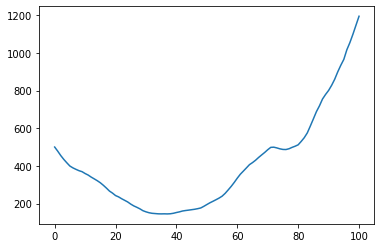

In [143]:
alpha = 0.1
a = 0.5
b = 0.5
K = 1000
R0 = 500
eps = 0.4
resourceSpec = ResourceSpec("GreedyAgents", alpha, K, R0, a, b, eps, 0.1 )
myresource = Resource(greedy_agentSpecs,resourceSpec)
for step_count in range(100):
  myresource.step()
myresource_df = myresource.dc.get_model_vars_dataframe()
# myresource.dc.get_agent_vars_dataframe()
plt.plot(myresource_df.resource)


Boat_1 activated 1 1
Boat_2 activated 2 1
Boat_3 activated 3 1


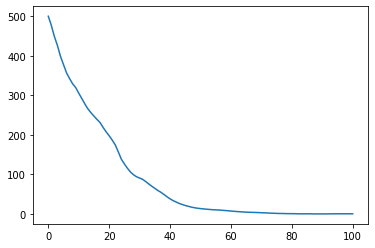

In [142]:
alpha = 0.1
a = 0.5
b = 0.5
K = 1000
R0 = 500
eps = 0.4
resourceSpec = ResourceSpec("MixedAgents", alpha, K, R0, a, b, eps, 0.1 )
myresource = Resource(mixed_agentSpecs,resourceSpec)
for step_count in range(100):
  myresource.step()
myresource_df = myresource.dc.get_model_vars_dataframe()
# myresource.dc.get_agent_vars_dataframe()
plt.plot(myresource_df.resource)

Boat_1 activated 3 1
Boat_2 activated 3 1
Boat_3 activated 3 1


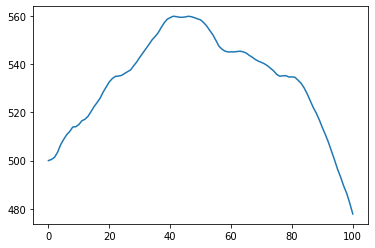

In [144]:
alpha = 0.1
a = 0.5
b = 0.5
K = 1000
R0 = 500
eps = 0.4
resourceSpec = ResourceSpec("CoinyAgents", alpha, K, R0, a, b, eps, 0.1 )
myresource = Resource(coiny_agentSpecs,resourceSpec)
for step_count in range(100):
  myresource.step()
myresource_df = myresource.dc.get_model_vars_dataframe()
# myresource.dc.get_agent_vars_dataframe()
plt.plot(myresource_df.resource)

In [ ]:
# from mesa.batchrunner import BatchRunner
# # parameters = {"n_agents": range(1, 20)}

# resourceSpec = ResourceSpec("CoinyAgents", alpha, K, R0, a, b, eps, 0.1 )
# myresource = Resource(coiny_agentSpecs,resourceSpec)
# batch_run = BatchRunner(MyModel, parameters, max_steps=50)
# #                         model_reporters={"n_agents": lambda m: m.schedule.get_agent_count()})
# batch_run.run_all()
# batch_df = batch_run.get_model_vars_dataframe()

In [31]:
# Resource parameters

# import numpy as np

# alpha = 0.1
# a = 0.5
# b = 0.5
# K = 1000
# R0 = 500

# # Exploitation effort
# E_star = np.power((alpha/K),(1/a))*np.power(R0,((1-b)/a))*np.power((K-R0),(1/a))
# E = E_star*1.2

# # Simulation parameters
# sigma = 1
# T = 1000
# N = T


In [34]:
E

1.5

In [ ]:
# mu = np.log(alpha)*np.ones(N)
# nu = np.log(K)*np.ones(N)
# epsilon = np.ones(N)
# E = E_star*1*np.ones(N)

# # Kernel matrix (here sum of RBF + Dirac)
# KernelMatrix = array(data =0, dim = c(N,N))
# l = 1 #Kernel parameter to be played with
# q = 0.1

# for (t in 1:N){
#   for (v in 1:N){
#     KernelMatrix[t,v]= q*exp(-l*abs(t-v)) #OU kernel, can be changed to any kernel
#   }
# }



In [ ]:
# here to show how to manually get groups of cells
# def manually_get_neighbourhood(agentInstance):
#   neighbors = []
#   x, y = agentInstance.pos
#   for dx in [-1, 0, 1]:
#       for dy in [-1, 0, 1]:
#           neighbors.append((x+dx, y+dy))  

# here to show how to get measures across all agents
# def compute_gini(model):
#     agent_wealths = [agent.wealth for agent in model.schedule.agents]
#     x = sorted(agent_wealths)
#     N = model.num_agents
#     B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
#     return (1 + (1/N) - 2*B)

# here to show how to move agents on a grid
    # def move(self):
    #   # other_agent = self.random.choice(self.model.schedule.agents)
    #     possible_steps = self.model.grid.get_neighborhood(
    #         self.pos,
    #         moore=True, # Von Neumann excludes diagonal neighbourhood on the grid
    #         include_center=False)
    #     new_position = self.random.choice(possible_steps)
    #     self.model.grid.move_agent(self, new_position)  

# https://dmnfarrell.github.io/bioinformatics/abm-mesa-network # here to show mesa with networkx
# https://pypi.org/project/mesa-SIR/ # here to show mesa with networkx
# https://dmnfarrell.github.io/bioinformatics/abm-mesa-python # here to show mesa with bokeh
# https://github.com/tpike3/multilevel_mesa # multi-level mesa networks
# https://github.com/projectmesa/mesa/tree/main/examples/forest_fire  # here to show mesa with geo


     
